# CM 50270 Reinforcement Learning: Coursework 2 


**Total number of marks:** 100. (This coursework will determine 10% of your final grade for CM 50270.)

**What to submit:** Completed Jupyter notebook (.ipynb file) that includes all source code. Please do not change the file name.

**Where to submit:** CM50270 Moodle page

This coursework will be __marked anonymously__. Please do not include any identifying information on the files you submit. 

You are required to __work individually__. You are welcome to discuss ideas with others but you must design your own implementation and write your own code.

__Do not plagiarise__. Plagiarism is a serious academic offence. For details on what it is and how to avoid it, please visit the following webpage: http://www.bath.ac.uk/library/help/infoguides/plagiarism.html

Restart the kernel and run all cells before submitting the notebook. This will guarantee that we will be able to run your code for testing.

Remember to save your work regularly. 

## Blackjack

In this exercise, you will implement **Monte Carlo Policy Evaluation (MCPE)** to learn the state-value function $V(s)$ for a given policy in the game of [blackjack](https://en.wikipedia.org/wiki/Blackjack).

### The game

**Rules.** We will use the version of the game discussed in the lectures where a single player (the agent) plays against the dealer. The player's objective is to obtain cards whose sum is as large as possible without exceeding 21. All face cards count as 10; an ace can count as either 1 or 11.

The game begins with two cards dealt to both the dealer and the player. The first of the dealer’s cards is face down and the second is face up. If the player has 21 immediately (for example, an ace and a face card), it is called a "blackjack". The player then wins unless the dealer also has a blackjack, in which case the game is a draw. If the player does not have a blackjack, then she can request additional cards, one by one (_hits_), until she either stops (_sticks_) or exceeds 21 (_goes bust_). If the player goes bust, she loses; if she sticks, then it becomes the dealer’s turn. 

The dealer hits or sticks according to a fixed strategy without choice: he sticks on any sum of 17 or greater, hits otherwise. If the dealer goes bust, then the player wins; otherwise, the outcome (win, lose, or draw) is determined by whose final sum is closer to 21.

**MDP formulation.** Playing blackjack is naturally formulated as an episodic finite MDP. Each game of blackjack is an episode. Rewards of +1, −1, and 0 are given for winning, losing, and drawing, respectively. All rewards until the end of the game are zero. We do not discount ($\gamma = 1$); therefore these terminal rewards are also the returns. The player’s actions are to `"hit"` or to `"stick"`. 

The states depend on the player’s cards and the dealer’s showing card. Assume that cards are dealt from an infinite deck (that is, with replacement) so that there is no advantage to keeping track of the cards already dealt. If the player holds an ace that she could count as 11 without going bust, then the ace is said to be _usable_. In this case it is always counted as 11 because counting it as 1 would make the sum 11 or less, in which case there is no decision to be made because, obviously, the player should always hit. Thus, the player makes decisions on the basis of three variables: 
- the player's current sum (an integer between 12 and 21);
- the dealer’s one showing card (an integer between 1 and 10; note that the ace is counted as 1 here); and
- whether or not the player holds a usable ace (a boolean). 

This makes for a total of 200 states. We represent the state as a numpy-array of length 3 that combines the just mentioned three variables in the given order. For example, if the player is given a 6 and a _jack_, and the dealer's showing card is an ace, the corresponding state will be the numpy array `[16, 1, False]`. The terminal state of the game will be denoted by the numpy array `[-1, -1, -1]`.

###  Blackjack code you may use if you wish

** Please feel free to skip this section and implement your own blackjack code **

We provide a `Blackjack` class that you can use to simulate blackjack games. The following cells in this section will walk you through the basic usage of this class by playing a couple of blackjack games.  

We import the blackjack module and create a blackjack environment called `env`. The constructor method has one argument called `verbose`. If `verbose=True`, the blackjack object will regularly print the progress of the game. This is useful for getting to know the game and the provided code or if you just want to play around. You may want to set `verbose=False` when you run thousands of episodes to complete the exercise below.

In [1]:
import blackjack
env = blackjack.Blackjack(verbose=True)

You can interact with the blackjack environment using the `make_step()` method. This method takes an `action` as input and computes the response of the environment. Specifically, this method returns the resulting `new_state` and the corresponding `reward` signal.

Before the player can perform actions, we have to start the game (e.g., draw starting hands). In order to start or reset a blackjack game, call the `make_step()` without specifying a specific action or by setting `action="reset"`.

We will now walk through several example games. We will specify a [random seed](https://en.wikipedia.org/wiki/Random_seed) for the NumPy pseudo random number generator every time before we reset the game. This allows us to keep these examples reproducible.

In [2]:
import numpy as np
np.random.seed(8)
new_state, reward = env.make_step(action="reset")
print("Initial state:", new_state)
print("Reward:", reward)

The game is reset.
Player's cards: [10, 10]
Dealer's showing card: [7]
Initial state: [20  7  0]
Reward: 0


The player drew two cards with face value 10 each. The dealer also drew two cards, but we can only see the second card, a 7. The player now can choose to "hit" or "stick". Most players would stick if they had 20 on their hand. We call again the `make_step()` method and specify `action="stick"`.

In [3]:
new_state, reward = env.make_step(action = "stick")
print("The player obtains a reward of", reward)
print("The new (terminal) state is:", new_state)

The dealer's cards are: [10, 7]
The dealer has 17 points.
PLAYER WINS!
The player obtains a reward of 1
The new (terminal) state is: [-1 -1 -1]


The player won and received a reward of 1. Whenever an episode ends, the environment object sets the internal variable `self.active` to `False`. This variable is set to `True` again when we _reset_ the game. You can use the `self.active` variable to check whether an episode has ended or not.

In [4]:
np.random.seed(9)
new_state, reward = env.make_step(action="reset")
print("New state:", new_state)

The game is reset.
Player's cards: [11, 7]
Dealer's showing card: [2]
New state: [18  2  1]


The player has already 18 points but has a _usable ace_, which she can transfer into a 1 whenever she would _go bust_. The player can thus "hit" and hope that she gets closer to 21. 

In [5]:
new_state, reward = env.make_step(action = "hit")

Player draws card: [2]
New sum of player's cards: [20]


Great! The player got another 2 points and has again 20 points. The player would probably want to "stick" again...

In [6]:
new_state, reward = env.make_step(action = "stick")

The dealer's cards are: [7, 2]
The dealer has 9 points.
Dealer draws card: [3]
New dealer sum [12]
Dealer draws card: [6]
New dealer sum [18]
PLAYER WINS!


The player won again! Let's play a last one.

In [7]:
np.random.seed(7)
new_state, reward = env.make_step()
print("Reward:", reward)

The game is reset.
Player's cards: [11, 10]
Dealer's showing card: [10]
Player has Blackjack!
The dealer's cards are: [6, 10]
PLAYER WINS!
Reward: 1


The player drew a "Blackjack", that is, an ace and a 10. The dealer's cards valued 16. The player won again and received a reward without having performed an action. Try out some more games to get familiar with the code!

### Instructions

Your task is to learn the state-value function for the policy **"Stick if the player's sum is 19 or higher, and hit otherwise."**. Your code should compute these state values using **Monte Carlo Policy Evaluation (MCPE)**. For your reference, the pseudo-code for MCPE is reproduced below from the textbook (Reinforcement Learning, Sutton & Barto, 1998, Section 5.1).
<img src="images/MCPE.png" style="width: 400px;"/>
The provided pseudo-code shows _first-visit_ MCPE. No state occurs twice during one game (episode) of Blackjack. In this case, first-visit MCPE and every-visit MCPE are identical.

You will have to provide a function `get_state_value(s, v)` that takes as input a state `s` (a numpy array of length 3 as described in the MDP formulation of blackjack) and the state values `v` that you computed. The `get_state_value(s, v)` should return the corresponding state value $V(s)$ as a float. There are no restrictions on how you store the state values `v`.

We will mark your code by calling `get_state_value(s, v)` for different valid states `s`. 

Make sure that your entire code runs in less than 2 minutes. You do not need to run MCPE for more than 100000 episodes.

0.0k/200.0k iterations complete.
10.0k/200.0k iterations complete.
20.0k/200.0k iterations complete.
30.0k/200.0k iterations complete.
40.0k/200.0k iterations complete.
50.0k/200.0k iterations complete.
60.0k/200.0k iterations complete.
70.0k/200.0k iterations complete.
80.0k/200.0k iterations complete.
90.0k/200.0k iterations complete.
100.0k/200.0k iterations complete.
110.0k/200.0k iterations complete.
120.0k/200.0k iterations complete.
130.0k/200.0k iterations complete.
140.0k/200.0k iterations complete.
150.0k/200.0k iterations complete.
160.0k/200.0k iterations complete.
170.0k/200.0k iterations complete.
180.0k/200.0k iterations complete.
190.0k/200.0k iterations complete.
200.0k/200.0k iterations complete.

44.28685641288757 seconds to execute.



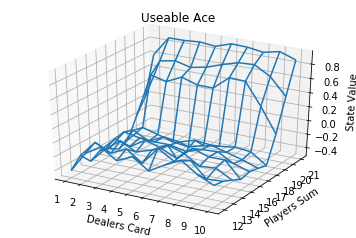

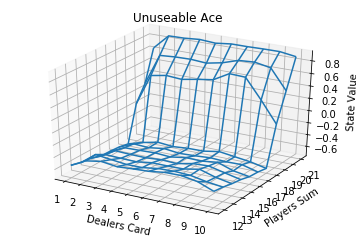

In [158]:
############################################################ RL CWK 2 ###########################################################

"""
Program to learn blackjack using monte carlo policy evaluation.
"""

############################################################ Imports ############################################################

import numpy as np
import blackjack
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
np.random.seed(42)

############################################################ Classes ############################################################

class MCPEforBlackjack:
    """
    Class to create a solver for blackjack values based on monte carlo policy evaluaation.  The precise algorithm is from the
    book Reinforcment Learning: An Introduction by Richard S. Sutton and Andrew G. Barto.  The class uses the provided blackjack
    module to perform game simulations.
    """

    def __init__(self, policy):
        """
        Class concstructor.
        """
        self.game = blackjack.Blackjack(verbose=False) # This is an instance of the game envrionment to learn on.
        self.values = np.zeros((10,10,2), dtype = float) # This is the values array it is of length 200 for each state.
        self.reward = [[[[] for i in range(2)] for i in range(10)] for i in range(10)]
        self.policy = policy # This is the minimum sum of the player to stick for.
        """
        Note that the above arrays are all 3D, this is to represent the different values in the state.  This means that the
        array of a provide state can be used almost directly as an index.

            - The first dimension is for the players sum.
            - The second dimension is for the shown card.
            - The third dimension is for an ace or not, a useable ace states exist at index [1].

        This is a super effecient way of doing things that involves minimal calcualtion or searching!
        """

    def convertToIndex(self, state):
        """
        This is to convert a given state into an index.
        """
        playerSum  = state[0]-12
        dealerCard = state[1]-1
        useableAce = int(state[2])
        return (playerSum, dealerCard, useableAce)

    def runGame(self):
        """
        This runs a game of blackjack according to the policy provided.  The function returns the state indexes visited and the
        return for the game wich is simply the reward for this particular solver.
        """
        statesVisited = [] # This is the list of indexes of states visited.
        newState, reward = self.game.make_step(action="reset") # Sets the game up with the first state.
        while True: # Infinite loop to continue game - risky as hell but whatevs.
            if np.array_equal(newState, np.array([-1,-1,-1])): # If game has ended returns the previous value and the list.
                return statesVisited, reward
            else: # If game has not ended simply appends the state index to the list
                statesVisited.append(self.convertToIndex(newState))
            if newState[0] >= self.policy: # stick policy
                newState, reward = self.game.make_step(action="stick")
            else: # hit policy
                newState, reward = self.game.make_step(action="hit")

    def updateReturns(self, statesVisited, reward):
        """
        Updates the returns based on the states visited and rewards from a single episode or game.
        """
        for i in statesVisited:
            self.reward[i[0]][i[1]][i[2]].append(reward)

    def performMCPE(self, iterations):
        """
        Performs the MCPE algorithm.  Note that the values are not calculated upon every iteration, this is wastefull
        calculation, this process might as well be done at the end after the rewards array is complete.
        """
        startTime = time.time()
        for i in range(iterations):
            statesVisited, reward = self.runGame()
            self.updateReturns(statesVisited, reward)
            # The following is simply to keep track of iterations
            if i%10000 == 0:
                print(str(i/1000)+"k/"+str(iterations/1000)+"k iterations complete.")
        print(str(iterations/1000)+"k/"+str(iterations/1000)+"k iterations complete.\n")
        endTime = time.time()
        print(endTime-startTime,"seconds to execute.\n")

    def computeValues(self):
        """
        after creating the lists of rewards, the values can be computed by averaging these lists.  Doing it seperately after
        creating the lists is vastly more effecient.
        """
        for i in range(10):
            for j in range(10):
                for k in range(2):
                    rewardList = self.reward[i][j][k]
                    if len(rewardList) != 0:
                        value = np.mean(self.reward[i][j][k])
                        self.values[i,j,k] = value

    def plotSurface(self, useableAce):
        """
        Plots a both surfaces for validation against the books values.
        """
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        x = range(1,11)
        y = range(12,22)
        x, y = np.meshgrid(x, y)
        ax.plot_wireframe(x, y, self.values[:,:,useableAce])
        ax.locator_params(axis='x', nbins=10)
        ax.locator_params(axis='y', nbins=10)
        ax.set_xlabel("Dealers Card")
        ax.set_ylabel("Players Sum")
        ax.set_zlabel("State Value")
        if useableAce == 1:
            ax.set_title("Useable Ace")
        if useableAce == 0:
            ax.set_title("Unuseable Ace")

    def getStateValue(self, state):
        """
        Gets the state value given a specific state.
        """
        index = self.convertToIndex(state)
        return self.values[index]

########################################################### Execution ###########################################################

solver = MCPEforBlackjack(19) # Creates the solver object for a policy of sticking with 19 or  above
solver.performMCPE(200000) # Solves it.  This only took 45 secs on a naff uni pc, so shuld be way unde 2 mins for your pc.
solver.computeValues() # Computes the values from the list of state returns.
solver.plotSurface(1) # Plots the graph for a useable ace for validation against book.
solver.plotSurface(0) # Plots the graph for an unuseable ace for validation against book.

#################################################################################################################################

In [157]:
def get_state_value(s, v):
    """
    Gets the state value for a given state.  I've left v in, incase you are using an automarker, however it is not used.
    Instead I just call up the global solver object, bad practice but nevermind.  The arg v can be literally anything.
    
    *** If you need the values array call up solver.values ***
    
    """
    sValue = solver.getStateValue(s)
    return sValue

print(get_state_value([20,9,0], 'null')) # Example using function.

0.696551724137931


In [ ]:
# This is a TEST CELL. We will use it to mark your solution. 
# All of your code must be written above this cell. 

In [ ]:
# This is a TEST CELL. 

In [ ]:
# This is a TEST CELL. 

In [ ]:
# This is a TEST CELL. 

In [ ]:
# This is a TEST CELL. 